In [1]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/2021/lesson2')

Mounted at /content/drive


# Discount Factor, Interpolation and Forward Rates

\begin{equation}
D_n = \cfrac{1}{(1+r)^{n}}
\end{equation}

* When the continuously-compounded hypothesis is used the discount factor becomes

\begin{equation}
D_n = e^{-rn}
\end{equation}

* Discount factors are usually presented as curves (*discount curves*) where each point represents a discount factor relative to a future date.

![alt text](https://drive.google.com/uc?id=1l6U9zDhejCPiI2D8y4Xu2vWJblAWChcA)

* Since usually discount factors are available only at discrete times some technique is needed to determine the factors at any time would be needed, this tool is called *interpolation*.

# Interpolation

## Linear interpolation

* Imagine to have sampled few data points, those are values of a function $f(x)$, where $x$ is a variable.

* It is often required to estimate the $f(x)$ at intermediate values of the variable $x$.

* Interpolation is a method to "construct" new points within a range of a discrete set of known data points. 

#### Example 1
* Assume you are going on holidays by car, there isn't much traffic so that you can drive at constant speed 
  * which gives a linear relation between travelled space and time i.e. $s = v \cdot t$;
  * which means that if you plot the distances $s$ as a function of the time $t$ you get a line with slope $v$.

* Few samples of the distance have been recorded:

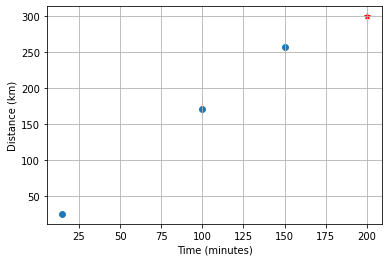

In [2]:
from matplotlib import pyplot as plt

t = [15, 100, 150]
s = [25.75, 171.7, 257.7]

t_ex = [200]
s_ex = [300]

plt.scatter(t, s, marker="o", s=35)
plt.scatter(t_ex, s_ex, marker="*", s=35, color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Distance (km)")
plt.grid(True)
plt.show()

* Given two samples of the car travelled distance $s_1$ and $s_2$ taken at two different times $t_1$ and $t_2$ you can linearly interpolate to find your position at intermediate times ($t_1 \leq t \leq t_2$ using the following relations:

$$s(t) = (1 - w)\cdot s_1 + w \cdot s_2\qquad(\textrm{with}~w = \frac{t - t_1}{t_2 - t_1})$$

  * The simple derivation of this relation is available in the lecture notes.

* This formula can be interpreted as a weighted average of the sampled distances, whit weights inversely related to the distance from interpolated point
  * the closer point has more influence than the farther point. 

\begin{equation*}
w_1 = (1 - w) = \cfrac{t_2 - t}{t_2 - t_1} \\
w_2 = w = \frac{t - t_1}{t_2 - t_1}
\end{equation*}

* If $s_1 = 25.75~\mathrm{km}\;(@t_1 = 15~\mathrm{min})$ and $s_2 = 171.7~\mathrm{km}\;(@t_2 = 100~\mathrm{min})$:

In [3]:
# interpolate at t = 60
s1 = 25.75
s2 = 171.7
t1 = 15
t2 = 100

t = 60
w = (t-t1)/(t2-t1)
s = (1-w)*s1 + w*s2
print (s)

103.01764705882351


![alt text](https://drive.google.com/uc?id=1sETZbf0Qb7shXD47e6GS4Sdsdv0uwL21)

#### Always Interpret Critically your Results

* In this case $t=60$ is in the middle of the interval $t_1, t_2$, so we expected a distance somehow in between $s_1, s_2$...

* If we believe the relation between our variables stays the same (e.g. keep the same constant velocity in our trip), we can use the same formula to extrapolate values outside our initial sample.


In [4]:
# distance travelled in 180 min trip (extrapolation)

t = 180
w = (t-t1)/(t2-t1)
s = (1-w)*s1 + w*s2
print (s)

309.0647058823529


### Log-linear interpolation

* When the function $f$ that we want to interpolate is an exponential we can fall back to the previous case by a simple variable transformation. 

$$p = \mathrm{exp}(c \cdot h)$$

$$s = \mathrm{log}(p) = \mathrm{log}(\mathrm{exp}(c \cdot h)) = c \cdot h$$

$$w = \frac{h - h_1}{h_2 - h_1}$$

$$s = (1 - w)\cdot s_1 + w \cdot s_2\;\;(\mathrm{remember \;now }\;s = \mathrm{log}(p))$$

$$p = \mathrm{exp}(s)$$

#### Example 2

* Atmospheric pressure decreases with the altitude (i.e. the highest I flight the lower is the pressure) following an exponential law:

$$p = p_0\cdot e^{-\alpha h}$$

* where
  * $h$ is the altitude
  * $p_0$ is the pressure at sea level
  * $\alpha$ is a constant

* Taking the logarithm of each side we get a linear relation which can be interpolated as before:

$$s = \mathrm{log}(p) = \mathrm{log}(p_0\cdot e^{-\alpha h}) = - \beta \cdot h$$

* remember to exponentiate back $s$ to get the original measure $p$.

* Assume that we have measured: $p_1 = 90~\mathrm{kPa}\;(h_1 = 1000~\mathrm{m})$ and $p_2 = 40~\mathrm{kPa}\;(h_2 = 7000~\mathrm{m})$ 
  * what will be the atmospheric pressure on top of the Mont Blanc ($4812~\mathrm{m}$) ? 
  * and on top of Mount Everest ($8848~\mathrm{m}$) ? 

In [6]:
# pressure on top of the Mont Blanc (interpolation)
from math import log, exp

p1 = 90
p2 = 40
h1 = 1000
h2 = 7000
s1 = log(p1)
s2 = log(p2)

h = 4812
w = (h-h1)/(h2-h1)
s = (1-w)*s1 + w*s2
print (s)
print (exp(s))

3.984598672960824
53.76370831775357


In [7]:
# pressure on top of the Mount Everest (extrapolation)
h = 8848
w = (h-h1)/(h2-h1)
s = (1-w)*s1 + w*s2
print (s)
print (exp(s))

3.4391129475193067
31.159305965991525


![](https://drive.google.com/uc?id=1h79pF8XHn0xx1SUMLWxKfmT4-ubwW5ST)

### Limitations of Linear Interpolation

* Interpolation is just an approximation and works well when either the function $f$ is linear or we are trying to interpolate between two points that are close enough to believe that $f$ is *almost* linear in that interval.

* It can be easily demonstrated that the approximation between two points on a given function gets worse with the second derivative of the function that is approximated. 
  * This is intuitively correct: the "curvier" the function the worse the approximations made with simple linear interpolation becomes.

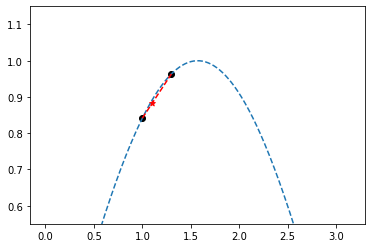

In [9]:
import numpy as np
from matplotlib import pyplot as plt

x = [1, 1.3]
y = np.sin(x)

xi = 1.1
z = np.interp(xi, x, y)
xs = np.arange(0,np.pi, 0.01)
plt.plot(xs, np.sin(xs), linestyle="--")
plt.plot([x[0],xi,x[1]], [y[0], z, y[1]], linestyle="--", color="red")
plt.scatter(x, y, marker="o", color="black")
plt.scatter(xi, z, marker="*", color="red")
plt.ylim(0.55, 1.15)
plt.show()

## Discount curve interpolation (Back to finance)

* Let's try to write a $\tt{python}$ class which interpolates some given discount factors.

* Needed data:
  * a list of pillars dates specifying the value dates of the given discount factors, $t_0,...,t_{n-1}$
  * a list of given discount factors, $D(t_0),...,D(t_{n-1})$
  * a pricing date ('today' date) which corresponds to $t=0$

* The input argument of the interpolation method will be the date at which we want to interpolate the discount factors.

* Since it holds $D=e^{-r(T-t)}$ the method will use a log-linear interpolation to return the value we are looking for.

$$d(t_i):=\mathrm{ln}(D(t_i))$$

$$d(t) = (1-w)d(t_i) + wd(t_{i+1});\;\;\;w=\frac{t-t_i}{t_{i+1}-t_i}$$

$$D(t) = \mathrm{exp}(d(t))$$

* where $i$ is such that $t_i \le t \le t_{i+1}$

* Instead of reinventing the wheel and perform the interpolation with our own code, we'll use the function `numpy.interp`.

In [10]:
# the numpy.interp function linearly interpolates
import numpy as np

x = [1,2,3]
y = [4,5,6]

np.interp(1.5, x, y)

4.5

In [11]:
# define the df function
from math import log, exp

class DiscountCurve:
  def __init__(self, pillars, dfs):
    self.start_date = pillars[0]
    self.pillars = [(p-self.start_date).days for p in pillars]
    self.dfs = [log(df) for df in dfs]

  def df(self, d):
    d_days = (d-self.start_date).days 
    return exp(np.interp(d_days, self.pillars, self.dfs))
  

In [14]:
from finmarkets import generate_dates
from datetime import date
from dateutil.relativedelta import relativedelta

pillars = generate_dates(date.today(), 36)
dfs = [1, 0.9, 0.8, 0.7]
dc = DiscountCurve(pillars, dfs)

df_date = date.today() + relativedelta(months=6)
df0 = dc.df(df_date)
print (df0)

0.9488202308929282


* This is almost OK, **but it won't work** because `numpy.interp` only accepts lists of numbers as arguments i.e. it doesn't automatically convert or interpret dates as numbers in any way, so it doesn't know how to interpolate them.

* We need to do the conversion ourselves before passing data to `numpy.interp`.

In [ ]:
# corrected function
from math import log, exp


In [ ]:
# now we can use the df function to get discount factors
# on value dates between the given pillar dates
from datetime import date
from finmarkets import generate_dates
from dateutil.relativedelta import relativedelta


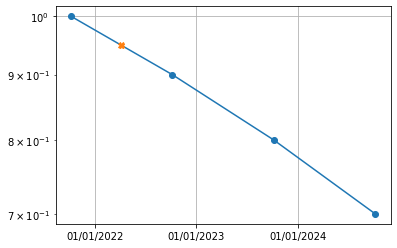

In [15]:
# let's see what these look like when plotted on a semi‐log graph
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

plt.semilogy(pillars, dfs, marker='o')
plt.semilogy(df_date, df0 , marker='X')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(True)
plt.show()

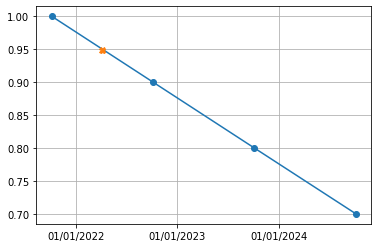

In [16]:
# let's see what these look like when plotted on a linear graph

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
plt.plot(pillars, dfs, marker='o')
plt.plot(df_date, df0 , marker='X')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(True)
plt.show()

# Forward Rates

* A forward rate is an interest rate applicable to a financial transaction that will take place in the future. 
  * It can be considered as the market’s expectation for future prices and can serve as an indicator of how it believes will perform.

* Contrary the spot rate is used by buyers and sellers looking to make an immediate purchase or sale.
  * It cannot be an indicator of market expectations.

## Calculating Forward Rates

* To calculate the forward rates we can exploit a no-arbitrage argument:
  * investing at rate $r_1$ for the period $(0, T_1)$ and then *reinvesting* at rate $r_{1,2}$ for the time period $(T_1, T_2)$ is equivalent to invest at rate $r_2$ for the time period $(0, T_2)$;
  * two investors shouldn't be able to earn money from arbitraging between different interest periods.

$$(1+r_1 T_1)(1+r_{1,2}(T_2 - T_1)) = 1 + r_2 T_2$$

* Solving for $r_{1,2}$ leads to

$$F(T_1, T_2) = r_{1,2} = \frac{1}{T_2-T_1}\Big(\frac{D(T_1)}{D(T_2)} - 1 \Big)~~~~\textrm{(where $D{(T_i)}=\frac{1}{1+r_iT_{i}}$)}$$

In [ ]:
# write class ForwardRate
import numpy as np
from math import exp


In [ ]:
# test the class
from datetime import date
observation_date = date(2020, 1, 1)

pillar_dates = [observation_date, 
                date(2021, 1, 1), 
                date(2022, 8, 1)]
rates = [0.05, 0.07, 0.08]


### 2008 Financial Crisis

* Historical series of the Euribor (6M) rate and the Eonia Overnight Indexed Swap (OIS-6M) rate over the time interval 2006-2011
  * before August 2007 the two rates display strictly overlapping trends differing of no more than 6 bps. 

![](https://drive.google.com/uc?id=1ifudtdyB2m005mc36WyX0jLlEXKu_Tek)

* In August 2007 however a sudden increase of the Euribor rate and a simultaneous decrease of the OIS rate leads to the explosion of the corresponding basis spread
  * touching the peak of 222 bps in October 2008, when Lehman Brothers filed for bankruptcy protection. 
  
* Successively the basis has sensibly reduced and stabilized between 40 and 60 bps 
  * the pre-crisis level has never been recovered though. 
  * similar behavior is observed for other index couples, e.g. Euribor 3M vs OIS 3M. 

* The reason of the abrupt divergence between the Euribor and OIS rates can be explained by considering:
  * monetary policy decisions adopted by international authorities in response to the financial turmoil; 
  * the impact of the credit crunch on the credit and liquidity risk perception of the market, coupled with the different financial meaning and dynamics of these rates. 

* The existence of such significant spread reflects the fact that after the crisis interest rate market has been segmented into subareas corresponding to instruments with different underlying rate tenors, characterized by different rate dynamics. 

* The OIS rate has been adopted as the discount rate because it is the best proxy for the risk-free rate involving daily transaction considered less risk-prone.

* Due to the large spread between risk-free rate and inter-bank lending rate during and after 2008 financial crisis it is not possible anymore to use a single curve for discounting and derivative valuation. 
  * The traditional single curve used for both cash flow projection and discounting turned out to be obsolete. The markets have since nearly switched to \emph{multi-curve framework}. 

* For example, to calculate the PV of a forward 6-month libor coupon, we need to simultaneously use two different discount curves:
  * the 6-month EURIBOR curve for determining the forward rate;
  * the EONIA curve for discounting the expected cash flow.

Essentially we will have to implement the following calculation:

$$\mathrm{coupon} = D_{\mathrm{EONIA}}(T_1) \times F_{\textrm{EURIBOR}}(T_1, T_2)$$

In [ ]:
from math import exp
from datetime import date

today = date(2020, 1, 1)
t1 = date(2020, 4, 1)
t2 = date(2020, 10, 1)
pillar_dates_eonia = [today, date(2021, 1, 1), date(2022, 10 ,1)]
eonia_rates = [1.0, 0.97, 0.72]
pillar_dates_libor = [today, date(2020, 6, 1), date(2020, 12 ,1)]
libor = [0.005, 0.01, 0.015]
